In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "disabled"
os.environ["WANDB_START_METHOD"] = "thread"

In [ ]:
# Setup & Mount Drive
from google.colab import drive
drive.mount('/content/drive')

!pip install -q transformers accelerate evaluate torch scikit-learn pandas

import pandas as pd
import numpy as np
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
import evaluate
import os
import random

# For reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.3 MB/s eta 0:00:00


In [ ]:
# Load & Prepare Data
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import random
import torch

# --- General setup ---
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# --- 1. Load dataset ---
df = pd.read_csv("/content/drive/MyDrive/nlp/clean_cv_data.csv")

# --- 2. Encode only main_label ---
le = LabelEncoder()
df["label"] = le.fit_transform(df["main_label"].astype(str))

label2id = {label: idx for idx, label in enumerate(le.classes_)}
id2label = {v: k for k, v in label2id.items()}

print("Label mapping:", label2id)

# --- 3. Stratified split (80/10/10) ---
train_df, temp_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=SEED
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["label"], random_state=SEED
)

print(f"Sizes: train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")

# --- 4. Reset indexes for cleanliness ---
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# --- 5. Show sample ---
train_df.head()

Label mapping: {'content': 0, 'header': 1, 'meta': 2}
Sizes: train=32000, val=4000, test=4001


,clean_text,main_label,sub_label,label
0,Mob : 98809-19218,meta,others,2
1,EXPERIENCE:,header,experience,1
2,H1 Grade,content,experience,0
3,Telesonic Networks Limited,content,experience,0
4,"· PROJECT NAME: AIRTEL 2G,3G,4G project of Eri...",content,project,0


In [ ]:
# Tokenization & Dataset Creation (Fixed)
from transformers import AutoTokenizer
from datasets import Dataset

# --- 1. Load tokenizer ---
MODEL_NAME = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# --- 2. Convert pandas DataFrames to HF Datasets and keep only needed columns ---
train_dataset = Dataset.from_pandas(train_df[["clean_text", "label"]])
val_dataset   = Dataset.from_pandas(val_df[["clean_text", "label"]])
test_dataset  = Dataset.from_pandas(test_df[["clean_text", "label"]])

# --- 3. Remove any extra columns like index to avoid errors ---
train_dataset = train_dataset.remove_columns([c for c in train_dataset.column_names if c not in ["clean_text", "label"]])
val_dataset   = val_dataset.remove_columns([c for c in val_dataset.column_names if c not in ["clean_text", "label"]])
test_dataset  = test_dataset.remove_columns([c for c in test_dataset.column_names if c not in ["clean_text", "label"]])

# --- 4. Define tokenization function ---
def tokenize_function(examples):
    # Ensure all inputs are strings
    texts = [str(t) for t in examples["clean_text"]]
    return tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=256
    )

# --- 5. Tokenize datasets ---
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset   = val_dataset.map(tokenize_function, batched=True)
test_dataset  = test_dataset.map(tokenize_function, batched=True)

# --- 6. Set format for PyTorch ---
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

print("Tokenization complete.")
print(train_dataset)

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/32000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4001 [00:00<?, ? examples/s]

Tokenization complete.
Dataset({
    features: ['clean_text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 32000
})


In [ ]:
# Model Setup
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch

num_labels = len(le.classes_)  # main_label classes

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

print("Model loaded and moved to", device)

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded and moved to cuda


In [ ]:
!pip install --upgrade transformers

In [ ]:
# Define Training Arguments
from transformers import TrainingArguments

OUTPUT_DIR = "/content/drive/MyDrive/nlp/deberta_main_label_model"

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=6,
    per_device_train_batch_size=8,     # smaller batch
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,     # simulate larger batch
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=2,
    fp16=True                          # enable mixed precision
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
# Define Metrics for Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

# --- Compute metrics function ---
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='macro'
    )
    acc = accuracy_score(labels, predictions)
    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

In [ ]:
# Initialize Trainer
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-1020827064.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.314600,0.290524,0.912250,0.870143,0.874273,0.868841
2,0.259800,0.293124,0.916750,0.874899,0.885923,0.864688
3,0.230700,0.269027,0.920500,0.884184,0.879495,0.889569
4,0.200200,0.295909,0.916500,0.878309,0.872029,0.888119
5,0.177100,0.319112,0.916750,0.876567,0.874855,0.878385
6,0.158200,0.329190,0.916500,0.878019,0.874383,0.882774


TrainOutput(global_step=12000, training_loss=0.2234129587809245, metrics={'train_runtime': 5308.0824, 'train_samples_per_second': 36.171, 'train_steps_per_second': 2.261, 'total_flos': 2.525934108672e+16, 'train_loss': 0.2234129587809245, 'epoch': 6.0})

Model and tokenizer saved to: /content/drive/MyDrive/nlp/deberta_main_label_model_final


              precision    recall  f1-score      support
content        0.957138  0.938940  0.947951  2735.000000
header         0.811744  0.878505  0.843806   535.000000
meta           0.841678  0.850889  0.846259   731.000000
accuracy       0.914771  0.914771  0.914771     0.914771
macro avg      0.870187  0.889445  0.879339  4001.000000
weighted avg   0.916601  0.914771  0.915446  4001.000000

Classification report saved to /content/drive/MyDrive/nlp/deberta_main_label_model_final/classification_report.csv
Confusion matrix saved to /content/drive/MyDrive/nlp/deberta_main_label_model_final/confusion_matrix.png
Metric trends plot saved to /content/drive/MyDrive/nlp/deberta_main_label_model_final/metric_trends.png


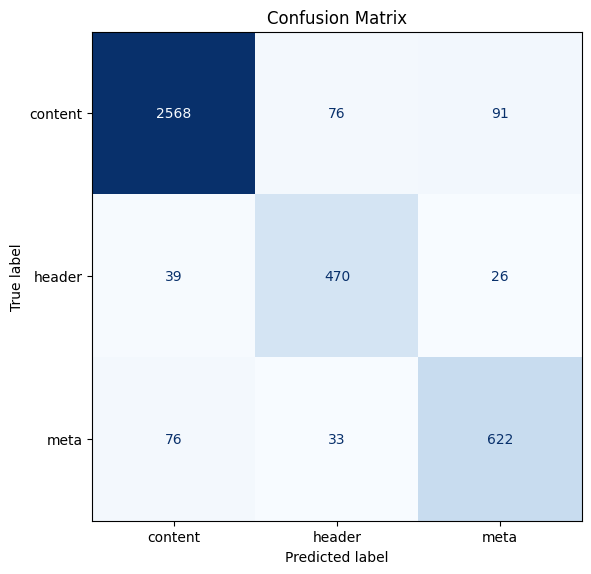

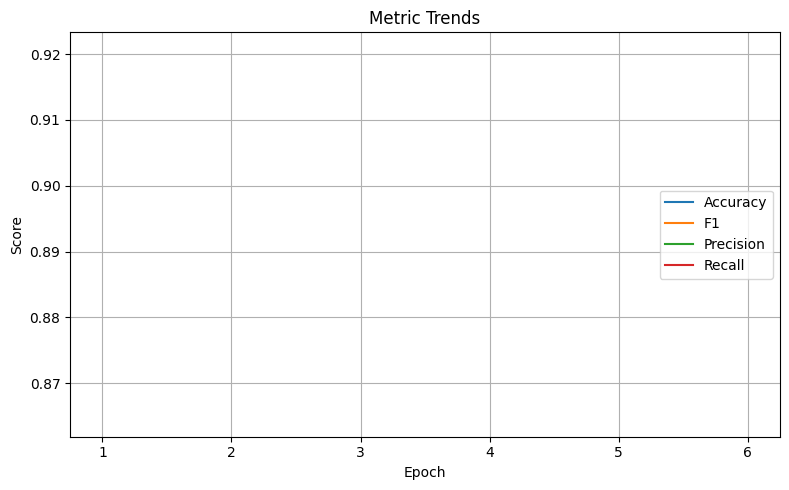

Training history saved to /content/drive/MyDrive/nlp/deberta_main_label_model_final/training_history.csv


In [ ]:
# --- 1. Save the fine-tuned model and tokenizer ---
SAVE_DIR = "/content/drive/MyDrive/nlp/deberta_main_label_model_final"
trainer.save_model(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)

print(f"Model and tokenizer saved to: {SAVE_DIR}")


# --- 2. Evaluate on the test set ---
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Run predictions
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = np.array(test_dataset["label"])

# Label mapping (use the one you printed earlier)
id2label = {0: "content", 1: "header", 2: "meta"}

# --- 3. Classification report ---
report = classification_report(
    y_true, y_pred, target_names=[id2label[i] for i in sorted(id2label.keys())], output_dict=True
)
report_df = pd.DataFrame(report).transpose()
print(report_df)

# Save classification report
report_path = f"{SAVE_DIR}/classification_report.csv"
report_df.to_csv(report_path, index=True)
print(f"\nClassification report saved to {report_path}")


# --- 4. Confusion matrix ---
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[id2label[i] for i in sorted(id2label.keys())])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix")
plt.tight_layout()

# Save confusion matrix plot
cm_path = f"{SAVE_DIR}/confusion_matrix.png"
plt.savefig(cm_path)
print(f"Confusion matrix saved to {cm_path}")


# --- 5. Plot metric trends over epochs using trainer.state.log_history ---
import matplotlib.pyplot as plt
import pandas as pd

# Convert trainer log history to DataFrame
history = pd.DataFrame(trainer.state.log_history)

# Only keep eval metrics per epoch
metric_cols = ["epoch", "eval_loss", "eval_accuracy", "eval_f1", "eval_precision", "eval_recall"]
history = history[[c for c in metric_cols if c in history.columns]]

if not history.empty:
    plt.figure(figsize=(8,5))
    for m in ["eval_accuracy", "eval_f1", "eval_precision", "eval_recall"]:
        if m in history.columns:
            plt.plot(history["epoch"], history[m], label=m.replace("eval_","").title())
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("Metric Trends")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{SAVE_DIR}/metric_trends.png")
    print(f"Metric trends plot saved to {SAVE_DIR}/metric_trends.png")
    plt.show()
else:
    print("No epoch logs found — skipping metric trend plot.")


# --- 6. Save log history as CSV for later analysis ---
history_path = f"{SAVE_DIR}/training_history.csv"
history.to_csv(history_path, index=False)
print(f"Training history saved to {history_path}")

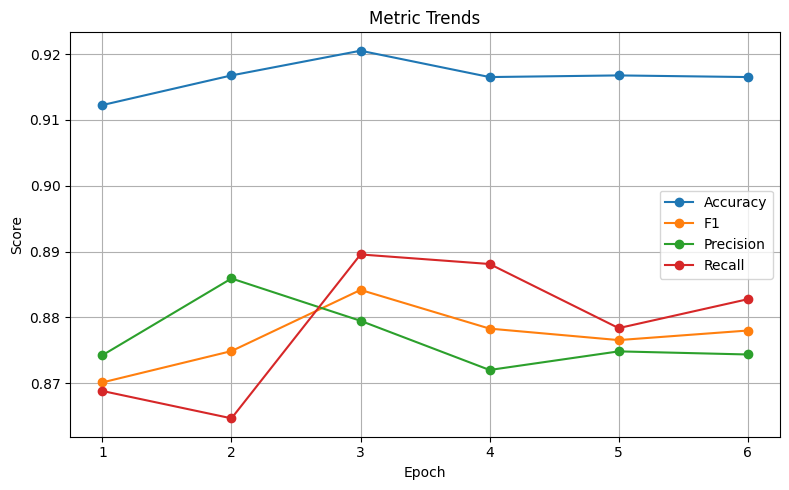

Metric trends plot saved to /content/drive/MyDrive/nlp/deberta_main_label_model_final/metric_trends.png


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert log history to DataFrame
history = pd.DataFrame(trainer.state.log_history)

# Only keep rows where evaluation metrics exist
eval_history = history.dropna(subset=["eval_loss"])  # or ["eval_accuracy"] etc.

plt.figure(figsize=(8,5))
metrics_to_plot = ["eval_accuracy", "eval_f1", "eval_precision", "eval_recall"]

for m in metrics_to_plot:
    if m in eval_history.columns:
        plt.plot(eval_history["epoch"], eval_history[m], marker='o', label=m.replace("eval_","").title())

plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Metric Trends")
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.savefig(f"{SAVE_DIR}/metric_trends.png")
plt.show()
print(f"Metric trends plot saved to {SAVE_DIR}/metric_trends.png")

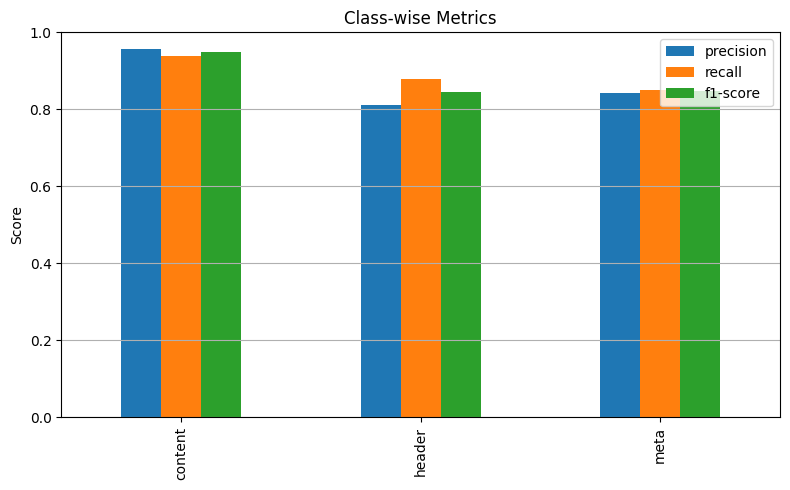

Class-wise metrics plot saved to /content/drive/MyDrive/nlp/deberta_main_label_model_final/classwise_metrics.png


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

report_df = pd.read_csv(f"{SAVE_DIR}/classification_report.csv", index_col=0)

# Drop summary rows
report_df = report_df.drop(index=["accuracy", "macro avg", "weighted avg"])

# Plot F1, Precision, Recall
report_df[["precision","recall","f1-score"]].plot(kind="bar", figsize=(8,5))
plt.title("Class-wise Metrics")
plt.ylabel("Score")
plt.ylim(0,1)
plt.grid(axis="y")
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/classwise_metrics.png")
plt.show()
print(f"Class-wise metrics plot saved to {SAVE_DIR}/classwise_metrics.png")

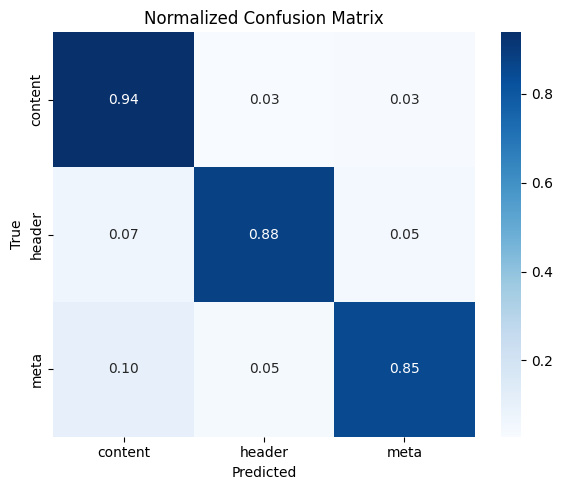

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6,5))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/confusion_matrix_normalized.png")
plt.show()

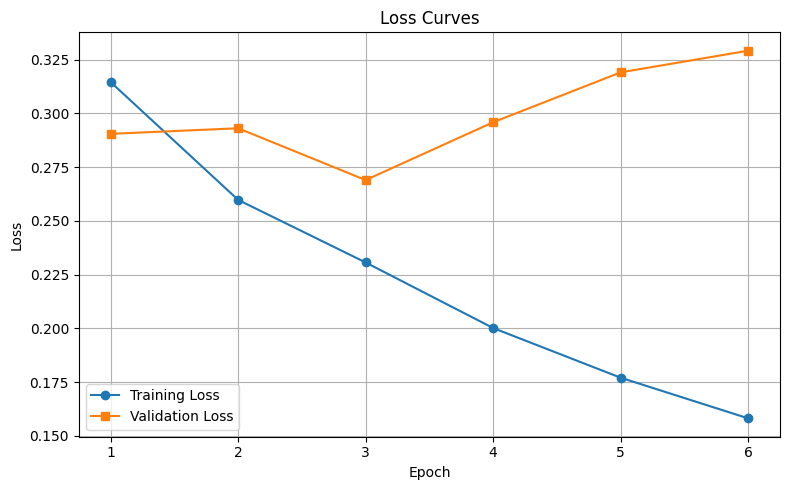

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract log history
logs = trainer.state.log_history

# Separate training loss and evaluation loss entries
train_losses = [x for x in logs if "loss" in x and "epoch" in x]
eval_losses = [x for x in logs if "eval_loss" in x]

# Get lists for plotting
train_epochs = [x["epoch"] for x in train_losses]
train_loss_vals = [x["loss"] for x in train_losses]

eval_epochs = [x["epoch"] for x in eval_losses]
eval_loss_vals = [x["eval_loss"] for x in eval_losses]

# Plot
plt.figure(figsize=(8,5))
plt.plot(train_epochs, train_loss_vals, marker='o', label="Training Loss")
plt.plot(eval_epochs, eval_loss_vals, marker='s', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/loss_curves.png")
plt.show()

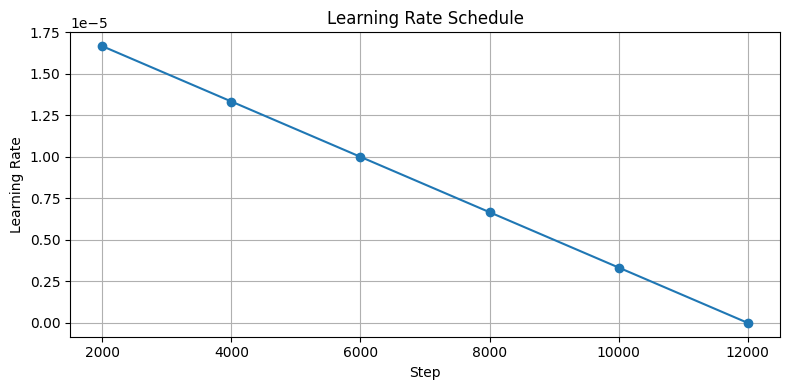

In [ ]:
import matplotlib.pyplot as plt

# Extract logs
logs = trainer.state.log_history

# Filter entries that have learning_rate
lr_logs = [x for x in logs if "learning_rate" in x and "step" in x]

if lr_logs:
    steps = [x["step"] for x in lr_logs]
    lrs = [x["learning_rate"] for x in lr_logs]

    plt.figure(figsize=(8,4))
    plt.plot(steps, lrs, marker='o')
    plt.xlabel("Step")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rate Schedule")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{SAVE_DIR}/learning_rate_schedule.png")
    plt.show()
else:
    print("No learning rate information found in log history.")

In [ ]:
import numpy as np

wrong_indices = np.where(y_true != y_pred)[0]
for idx in wrong_indices[:10]:  # show 10 samples
    print(f"Text: {df.iloc[idx]['clean_text']}")
    print(f"True: {le.inverse_transform([y_true[idx]])[0]}, Pred: {le.inverse_transform([y_pred[idx]])[0]}")
    print("-"*50)

Text: PROFESSIONAL SUMMARY:
True: header, Pred: meta
--------------------------------------------------
Text: Responsibilities:
True: meta, Pred: header
--------------------------------------------------
Text: · Involved In participation of regular sprint planning status meetings to discuss the risk arising in ongoing sprint with teammates and team lead.
True: meta, Pred: content
--------------------------------------------------
Text: · Have worked on Java, Spring, Hibernate, Oracle Sql developer, IBM Websphere, SoapUI, JMS.
True: meta, Pred: content
--------------------------------------------------
Text: Responsibilities:
True: meta, Pred: content
--------------------------------------------------
Text: · Involved in Coding, Deployment.
True: meta, Pred: content
--------------------------------------------------
Text: 2014 M.C.A from ASM’s College of Commerce, Science and Information Technology, Pune University
True: header, Pred: content
--------------------------------------------